# Credit Default Swaps (CDS) Cashflows & Survival Probabilities

In this notebook, we will work with a single CDS instrument definition to demonstrate how to access and interpret **all CDS fields** returned by the analytics response.

You will be able to:

- Define Single Name CDS instruments with **instrument code (RIC)**
- Configure pricing settings
- Explore main analytics fields: description, valuation, nominal measures, pricing analysis, spread measures and cash-flows
- Plot CDS Cashflows, DFs & Survival Probabilities


## Imports

Import the following necessary modules:

- `lseg_analytics.pricing.instruments.cds` - for CDS instruments definitions and analytics

This notebook uses external libraries **pandas, matplotlib, IPython**; please ensure they are installed in your Python environment (e.g. 'pip install pandas') before running the code.

In [1]:
from lseg_analytics.pricing.instruments import cds

import pandas as pd
import json
import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import display

## Data Preparation

To define a CDS instrument you need to follow a structured 3-step process:

1. **CDS Definition** - Specify basic CDS either with instrument code (RIC) or with premium and protection legs
2. **CDS Instrument Definition** - Create the instrument object
3. **Pricing Preferences** - Configure pricing parameters, optional

In [2]:
# Create CDS definition with instrument code (RIC)
cds_definition = cds.CdsDefinition(
    instrument_code="BNPP5YEUAM=R"                                          # BNP Paribas 5Y EUR CDS RIC
)

# Create CDS instrument from definition
cds_instrument = cds.CdsDefinitionInstrument(
    definition=cds_definition
)

print("CDS instrument created from RIC")

# Configure pricing parameters, optional
pricing_params = cds.CdsPricingParameters(
    valuation_date = dt.datetime.strptime("2023-03-01", "%Y-%m-%d"),          # Valuation date
    market_data_date = dt.datetime.strptime("2023-03-01", "%Y-%m-%d"),        # Market data date
    report_ccy = "USD"                                                        # Report currency
)
print("Pricing parameters configured")

CDS instrument created from RIC
Pricing parameters configured


## Request Execution

In [3]:
# Execute the calculation using the price() function with error handling
try:
    # The 'definitions' parameter accepts a list of request items for batch processing
    response = cds.price(
        definitions=[cds_instrument],
        pricing_preferences=pricing_params
    )
    errors = [a.error for a in response.data.analytics if a.error]
    if errors:
        raise Exception(errors[0].message)
    print("CDS pricing execution completed")
except Exception as e:
    print(f"Price Calculation failed: {str(e)}")
    raise

CDS pricing execution completed


## Results Display

#### Key Sections in the `response` JSON

- **definitions**: Instrument setup (e.g., instrument code, protection leg, premium leg), as CdsDefinition.
- **pricingPreferences**: Valuation date, price side, currency settings.
- **analytics**:
  - **tabularData**: Main analytics table with `data`, `headers`, `statuses` (all analytics fields, including arrays and scalars)
  - **description**: Instrument summary and static reference data (e.g., notional, dates, conventions)
  - **valuation**: Key valuation results (e.g., marketValueInDealCcy, upfrontAmount, accrued values)
  - **nominalMeasures**: Risk and sensitivity measures (e.g., CR01, DV01, RR01, jump to default, default probability)
  - **pricingAnalysis**: Core pricing metrics (e.g., spreads, rates, recovery, price)
  - **spreadMeasures**: Spread-based risk metrics (e.g., conventionalSpreadBp)
  - **cashflows**: 
    - **Single values**: nextCouponDate, cashAmountInDealCcy, cashAmountInReportCcy (shown in one DataFrame)
    - **Arrays**: cashFlowDatesArray, cashFlowTotalAmountsInDealCcyArray, cashFlowDiscountFactorsArray, cashFlowSurvivalProbabilitiesArray (shown in a separate DataFrame)
  - **error**: Root cause of the issue, if any

We give below some details on description, valuation, nominalMeasures, pricingAnalysis, spreadMeasures and cashflows sections

### Description

CDS Instrument Details

In [4]:
# Extract analytics section from response
analytics = response.data.analytics[0]

# Access description data from response
description_dict = analytics.description.as_dict()
df_description = pd.DataFrame(list(description_dict.items()), columns=["Field", "Value"])
display(df_description)

,Field,Value
0,instrumentCode,BNPP5YEUAM=R
1,instrumentDescription,BNP.EUR.SNRFOR.MM
2,referenceEntity,BNPP5YEUAM=R
3,notionalCcy,EUR
4,notionalAmount,1000000.0
5,reportCcy,USD
6,settlementConvention,3WD
7,settlementDate,2023-03-06
8,tradeDate,2023-03-01T00:00:00Z
9,stepInDate,2023-03-02T00:00:00Z


### Valuation

Detailed CDS valuation

In [5]:
# Display valuation as DataFrame (if available)
valuation = analytics.valuation
if valuation:
    display(pd.DataFrame(valuation.as_dict().items(), columns=["Field", "Value"]))
else:
    print("No valuation data available")

,Field,Value
0,accruedDays,72.000000
1,accruedPercent,0.200000
2,accruedAmountInDealCcy,-2000.000000
3,accruedAmountInReportCcy,-2133.400000
4,upfrontAmountInDealCcy,-22251.890099
5,upfrontAmountInReportCcy,-23736.091168
6,marketValueInDealCcy,-24243.835219
7,marketValueInReportCcy,-25860.899028
8,cleanMarketValueInDealCcy,-22244.499487
9,cleanMarketValueInReportCcy,-23728.207603


### Nominal Measures 
Key risk measures used in CDS valuation and sensitivity analysis

In [6]:
# Access nominal measures from response
nominal_dict = analytics.nominal_measures.as_dict()
df_nominal = pd.DataFrame(list(nominal_dict.items()), columns=["Field", "Value"])
display(df_nominal)

,Field,Value
0,cr01Bp,4.501163
1,cr01AmountInDealCcy,450.116316
2,cr01AmountInReportCcy,480.139074
3,dv01Bp,0.052571
4,dv01AmountInDealCcy,5.257069
5,dv01AmountInReportCcy,5.607716
6,rr01Bp,3.772665
7,rr01AmountInDealCcy,377.266538
8,rr01AmountInReportCcy,402.430216
9,jumpToDefaultBp,6222.518901


### Pricing Analysis

Pricing details to get a better understanding of the valuation

In [7]:
# Access pricing analysis from response
pricing_dict = analytics.pricing_analysis.as_dict()
df_pricing = pd.DataFrame(list(pricing_dict.items()), columns=["Field", "Value"])
display(df_pricing)

,Field,Value
0,marketDataDate,2023-03-01T00:00:00Z
1,valuationDate,2023-03-01T00:00:00Z
2,fixedRatePercent,1.0
3,recoveryRatePercent,40.0
4,upfrontPercent,-2.225189
5,pricePercent,102.425189
6,cleanPricePercent,102.225189
7,dealSpreadBp,100.0
8,parSpreadBp,49.606962


### Spread Measures - Risk Metrics
The spread for which the NPV of the CDS equals to the upfront amount for a given coupon. The value is expressed in basis points.

In [8]:
# Access spread measures from response
spread_dict = analytics.spread_measures.as_dict()
df_spread = pd.DataFrame(list(spread_dict.items()), columns=["Field", "Value"])
display(df_spread)

,Field,Value
0,conventionalSpreadBp,49.4447


### Cashflows - Main Fields
Three fields are represented:
- `nextCouponDate`: The first regular interest payment date following `settlementDate`.
- `cashAmountInDealCcy`: the amount which should be paid by the protection buyer to the protection seller on SettlementDate, including the accrued amount. If not specified, it is computed as [`UpfrontAmountInDealCcy` + `AccruedAmountInDealCcy`]. The value is expressed in the deal currency.
- `cashAmountInReportCcy`: same amount as `cashAmountInDealCcy` but expressed in the report currency

In [9]:
# Access cashflows from response
cashflow_dict = analytics.cashflows.as_dict()

# Keys to group together
main_keys = ["nextCouponDate", "cashAmountInDealCcy", "cashAmountInReportCcy"]
main_cashflows = {k: cashflow_dict[k] for k in main_keys if k in cashflow_dict}

# DataFrame for main cashflow fields
df_main_cashflows = pd.DataFrame(list(main_cashflows.items()), columns=["Field", "Value"])
display(df_main_cashflows)

,Field,Value
0,nextCouponDate,2023-03-20
1,cashAmountInDealCcy,-24251.890099
2,cashAmountInReportCcy,-25869.491168


### Cashflows - Payments Schedule

The other future cash-flows with their associated discount factor and survival probability

In [10]:
# Extract other Cap/Floor cashflow fields (array values)
other_cashflows_data = {key: value for key, value in cashflow_dict.items() if key not in main_keys and isinstance(value, list)}

# Convert to DataFrame
df_other_cashflows = pd.DataFrame(other_cashflows_data)

# Other cashflows DataFrame
display(df_other_cashflows)


,cashFlowDatesArray,cashFlowTotalAmountsInDealCcyArray,cashFlowDiscountFactorsArray,cashFlowSurvivalProbabilitiesArray
0,2023-03-20,2500.000000,0.998736,0.999817
1,2023-06-20,2555.555556,0.990946,0.998884
2,2023-09-20,2555.555556,0.981860,0.997618
3,2023-12-20,2527.777778,0.972566,0.996364
4,2024-03-20,2527.777778,0.963232,0.994787
5,2024-06-20,2555.555556,0.954105,0.993191
6,2024-09-20,2555.555556,0.945431,0.991597
7,2024-12-20,2527.777778,0.937319,0.990023
8,2025-03-20,2500.000000,0.929738,0.987980
9,2025-06-20,2555.555556,0.922425,0.985889


### Plot of CDS Cashflows, Discount Factors & Survival Probabilities

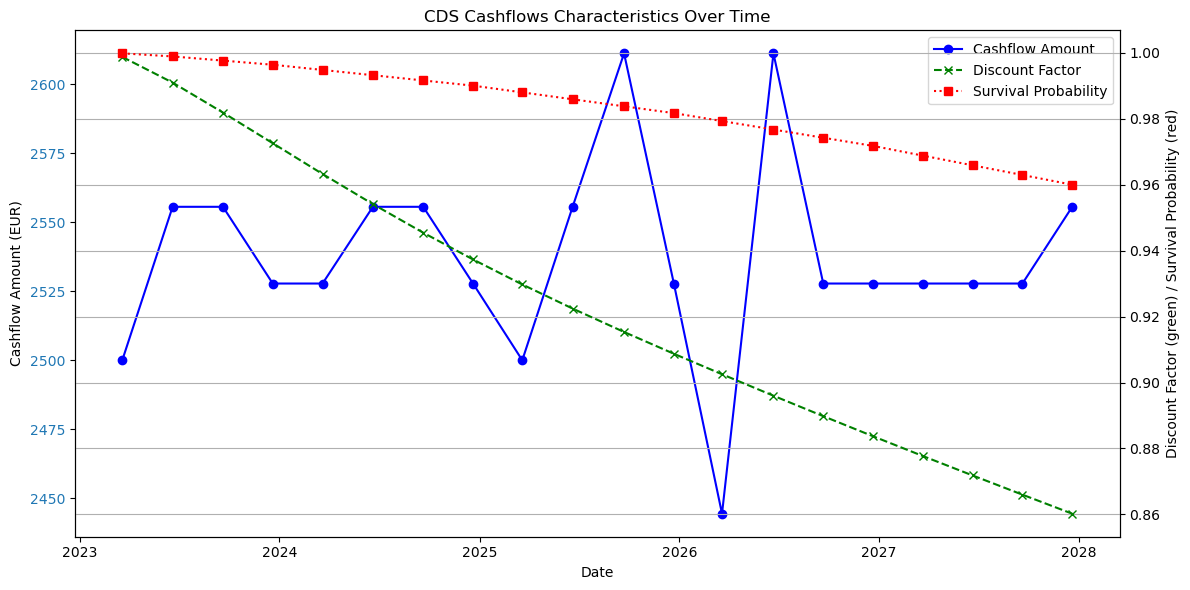

In [11]:
df = df_other_cashflows.copy()
df["cashFlowDatesArray"] = pd.to_datetime(df["cashFlowDatesArray"])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary axis: Cashflow Amounts
ax1.plot(df["cashFlowDatesArray"], df["cashFlowTotalAmountsInDealCcyArray"],
         label="Cashflow Amount", color="blue", marker="o")
ax1.set(xlabel="Date", ylabel="Cashflow Amount (EUR)")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Secondary axis: Discount Factors & Survival Probabilities
ax2 = ax1.twinx()
ax2.plot(df["cashFlowDatesArray"], df["cashFlowDiscountFactorsArray"],
         label="Discount Factor", color="green", linestyle="--", marker="x")
ax2.plot(df["cashFlowDatesArray"], df["cashFlowSurvivalProbabilitiesArray"],
         label="Survival Probability", color="red", linestyle=":", marker="s")
ax2.set_ylabel("Discount Factor (green) / Survival Probability (red)", color="black")
ax2.tick_params(axis="y", labelcolor="black")

ax1.legend(ax1.get_lines() + ax2.get_lines(), [l.get_label() for l in ax1.get_lines() + ax2.get_lines()], loc="upper right")
plt.title("CDS Cashflows Characteristics Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
